## Model Drift Removal

This is a test notebook for model drift removal. The model may have a significant drift over time and, in order to remove the drift, we look for linear (or higher order trend) in output variables. For this, we compute mean of required variables over all ensembles and simulations (irrespetive of start year). We compute yearly-mean to remove seasonal cycle and save these datasets for further analysis.   

In [1]:
import numpy as np
import scipy as sc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
## ------ Read Data (few tests for check only) ------------------ ##

ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'hfbasinpmdiff_atlantic', 'hfovgyre_atlantic', 'hfovovrt_atlantic', 'sophtadv_atlantic', 
            'sltbasin_atlantic', 'sltbasinpmdiff_atlantic', 'sltovgyre_atlantic', 'sltovovrt_atlantic', 'sopstadv_atlantic',
            'zomsfatl', 'zosalatl','zosrfatl']

ds = []

# Loop over year to combine indivual year files
for year in range(1960, 2017, 20):
    
    d = xr.open_dataset(ppdir + str(year) + "_diaptr.nc", chunks={'r':1})
    d = d.get(var_list)
    ds.append(d)
    
ds = xr.concat(ds, dim='start_year')

ds = ds.assign(start_year = np.arange(1960, 2017, 20))

ds = ds.chunk({'start_year': 1})

print(ds)

<xarray.Dataset>
Dimensions:                  (deptht: 75, depthw: 75, r: 10, start_year: 3, time_counter: 125, x: 1, y: 451)
Coordinates:
    nav_lon                  (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
  * deptht                   (deptht) float32 0.50576 1.5558553 ... 5902.0576
  * depthw                   (depthw) float32 0.0 1.0239066 ... 5596.249 5800.0
  * time_counter             (time_counter) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nav_lat                  (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    time_centered            (start_year, time_counter) object dask.array<shape=(3, 125), chunksize=(1, 125)>
  * start_year               (start_year) int64 1960 1980 2000
Dimensions without coordinates: r, x, y
Data variables:
    hfbasin_atlantic         (start_year, r, time_counter, y, x) float32 dask.array<shape=(3, 10, 125, 451, 1), chunksize=(1, 1, 125, 451, 1)>
    hfbasinpmdiff_atlantic   (start_year, r, time_counter, y, x) floa

In [7]:
ds.isel(start_year=0)['time_centered'].values

array([cftime.Datetime360Day(1960, 11, 16, 0, 0, 0, 0, 0, 316),
       cftime.Datetime360Day(1960, 12, 16, 0, 0, 0, 0, 2, 346),
       cftime.Datetime360Day(1961, 1, 16, 0, 0, 0, 0, 4, 16),
       cftime.Datetime360Day(1961, 2, 16, 0, 0, 0, 0, 6, 46),
       cftime.Datetime360Day(1961, 3, 16, 0, 0, 0, 0, 1, 76),
       cftime.Datetime360Day(1961, 4, 16, 0, 0, 0, 0, 3, 106),
       cftime.Datetime360Day(1961, 5, 16, 0, 0, 0, 0, 5, 136),
       cftime.Datetime360Day(1961, 6, 16, 0, 0, 0, 0, 0, 166),
       cftime.Datetime360Day(1961, 7, 16, 0, 0, 0, 0, 2, 196),
       cftime.Datetime360Day(1961, 8, 16, 0, 0, 0, 0, 4, 226),
       cftime.Datetime360Day(1961, 9, 16, 0, 0, 0, 0, 6, 256),
       cftime.Datetime360Day(1961, 10, 16, 0, 0, 0, 0, 1, 286),
       cftime.Datetime360Day(1961, 11, 16, 0, 0, 0, 0, 3, 316),
       cftime.Datetime360Day(1961, 12, 16, 0, 0, 0, 0, 5, 346),
       cftime.Datetime360Day(1962, 1, 16, 0, 0, 0, 0, 0, 16),
       cftime.Datetime360Day(1962, 2, 16, 0, 0, 0, 0, 

### Testing Doug'method (DCPP 2016 paper)

Consider winter seasons DJF in the time period 1970 - 2016. We compute average over these seasonal mean values while retaining the lead year information. For example, for 1st DJF - consider hindcasts 1970 - 2016, for 2nd DJF consider hindcasts 1969- 2015 etc. Compute the mean for all ensembles separately and substract this mean to obtain anomaly trend.

In [18]:
year1, year2 = (int(1980), int(2016))

year, lead_year = (1981, 1)

ds1 = ds.sel(start_year = year - lead_year).isel(time_counter=slice(1 + 12*lead_year, 4 + 12*lead_year))

In [20]:
ds1

<xarray.Dataset>
Dimensions:                  (deptht: 75, depthw: 75, r: 10, time_counter: 3, x: 1, y: 451)
Coordinates:
    nav_lon                  (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
  * deptht                   (deptht) float32 0.50576 1.5558553 ... 5902.0576
  * depthw                   (depthw) float32 0.0 1.0239066 ... 5596.249 5800.0
  * time_counter             (time_counter) float64 0.0 0.0 0.0
    nav_lat                  (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    time_centered            (time_counter) object dask.array<shape=(3,), chunksize=(3,)>
    start_year               int64 1980
Dimensions without coordinates: r, x, y
Data variables:
    hfbasin_atlantic         (r, time_counter, y, x) float32 dask.array<shape=(10, 3, 451, 1), chunksize=(1, 3, 451, 1)>
    hfbasinpmdiff_atlantic   (r, time_counter, y, x) float32 dask.array<shape=(10, 3, 451, 1), chunksize=(1, 3, 451, 1)>
    hfovgyre_atlantic        (r, time_counter,

### Testing combining data irrespective of start year

In [6]:
ds_save = []

for j in range(0,len(ds.start_year)):
    
    tmp = ds.sum('r').isel(start_year=j, time_counter=slice(2,122)).groupby('time_centered.year').mean('time_counter')
    
    tmp = tmp.assign(year = np.arange(1, 11)) # to have same year values to compute mean
    
    ds_save.append(tmp)
    
    #if (j==0):
    #    ds_save = tmp
    #else:
    #    ds_save = ds_save + tmp
        
ds_save = sum(ds_save)       
ds_save = ds_save / (len(ds.start_year) * len(ds.r))
ds_save = ds_save.drop('start_year')

In [7]:
ds_save

<xarray.Dataset>
Dimensions:                  (deptht: 75, depthw: 75, x: 1, y: 451, year: 10)
Coordinates:
  * deptht                   (deptht) float32 0.50576 1.5558553 ... 5902.0576
  * year                     (year) int64 1 2 3 4 5 6 7 8 9 10
  * depthw                   (depthw) float32 0.0 1.0239066 ... 5596.249 5800.0
    nav_lon                  (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat                  (y, x) float32 3.9967546 4.246108 ... 79.98739
Dimensions without coordinates: x, y
Data variables:
    hfbasin_atlantic         (year, y, x) float32 dask.array<shape=(10, 451, 1), chunksize=(1, 451, 1)>
    hfbasinpmdiff_atlantic   (year, y, x) float32 dask.array<shape=(10, 451, 1), chunksize=(1, 451, 1)>
    hfovgyre_atlantic        (year, y, x) float32 dask.array<shape=(10, 451, 1), chunksize=(1, 451, 1)>
    hfovovrt_atlantic        (year, y, x) float32 dask.array<shape=(10, 451, 1), chunksize=(1, 451, 1)>
    sophtadv_atlantic        (year, y, x) floa

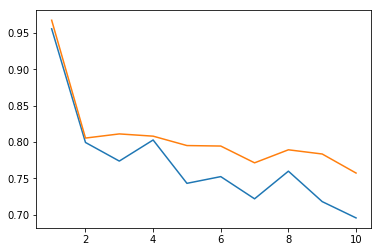

In [5]:
plt.plot(np.arange(1,11), tmp['hfbasin_atlantic'].isel(y=10,x=0) / len(ds.r))
plt.plot(np.arange(1,11), ds_save['hfbasin_atlantic'].isel(y=10,x=0))

### Linear Drift in overturning, heat/salt transports

In [3]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/"

ds = xr.open_dataset(ppdir + 'Drift_diaptr.nc')
print(ds)

<xarray.Dataset>
Dimensions:                  (deptht: 75, depthw: 75, x: 1, y: 451, year: 10)
Coordinates:
    nav_lon                  (y, x) float32 ...
  * deptht                   (deptht) float32 0.50576 1.5558553 ... 5902.0576
  * depthw                   (depthw) float32 0.0 1.0239066 ... 5596.249 5800.0
  * year                     (year) int64 1 2 3 4 5 6 7 8 9 10
    nav_lat                  (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    hfbasin_atlantic         (year, y, x) float32 ...
    hfbasinpmdiff_atlantic   (year, y, x) float32 ...
    hfovgyre_atlantic        (year, y, x) float32 ...
    hfovovrt_atlantic        (year, y, x) float32 ...
    sophtadv_atlantic        (year, y, x) float32 ...
    sltbasin_atlantic        (year, y, x) float32 ...
    sltbasinpmdiff_atlantic  (year, y, x) float32 ...
    sltovgyre_atlantic       (year, y, x) float32 ...
    sltovovrt_atlantic       (year, y, x) float32 ...
    sopstadv_atlantic        (year, 

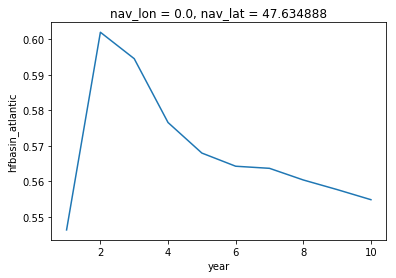

In [4]:
ds['hfbasin_atlantic'].isel(x=0,y=200).plot()

In [5]:
p = ds['hfbasin_atlantic'].isel(x=0).polyfit(dim='year', deg=1)

AttributeError: 'DataArray' object has no attribute 'polyfit'

In [2]:
!pip list

Package                  Version
------------------------ ------------
alabaster                0.7.12
asn1crypto               0.24.0
astroid                  2.1.0
atomicwrites             1.2.1
attrs                    18.2.0
Babel                    2.6.0
backcall                 0.1.0
backports.ssl            0.0.9
basemap                  1.2.0
beautifulsoup4           4.6.3
bokeh                    1.0.2
boto3                    1.9.67
botocore                 1.12.68
bottle                   0.12.13
Cartopy                  0.17.0
certifi                  2021.5.30
cf-units                 2.0.2
cffi                     1.11.5
cftime                   1.0.3.4
chardet                  3.0.4
Click                    7.0
click-plugins            1.0.4
cligj                    0.5.0
cloudpickle              0.6.1
cryptography             2.3.1
cycler                   0.10.0
Cython                   0.29.2
cytoolz                  0.9.0.1
dask                     1.0.0
decorator   